In [54]:
import geopandas as gpd
df = gpd.read_file("./NC_VTD.shp")

In [58]:
from gerrychain import Graph
import json
import geopandas as gpd

dual_graph = Graph.from_file("./NC_VTD.shp", ignore_errors=True)
dual_graph.to_json("./NC_VTD.json")

graph = Graph.from_json("./NC_VTD.json")


/Users/sherzodnimatullo/code/projects/416/gerrychain/env/lib/python3.10/site-packages/gerrychain/graph/adjacency.py:21: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometries[i].id = i
/Users/sherzodnimatullo/code/projects/416/gerrychain/env/lib/python3.10/site-packages/gerrychain/graph/adjacency.py:23: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(geometries)


In [60]:
from gerrychain import Partition
from gerrychain.updaters import cut_edges

parition = Partition(graph, "CD", {"cut_edges": cut_edges})

parition.graph.nodes[0]

{'boundary_node': False,
 'area': 21353099.75692615,
 'ALAND10': 1951715.9999999998,
 'AWATER10': 32157.0,
 'VTD': '3700106W',
 'County': '37001',
 'VTD_Key': '3700106W',
 'VTD_Name': '06W',
 'PL10AA_TOT': 1973,
 'PL10VA_TOT': 1505,
 'EL08G_GV_D': 330,
 'EL08G_GV_R': 301,
 'EL08G_GV_L': 24,
 'EL08G_GV_T': 655,
 'EL08G_USS_': 335,
 'EL08G_US_1': 288,
 'EL08G_US_2': 26,
 'EL08G_US_3': 1,
 'EL08G_US_4': 650,
 'EL10G_USS_': 133,
 'EL10G_US_1': 225,
 'EL10G_US_2': 12,
 'EL10G_US_3': 0,
 'EL10G_US_4': 370,
 'EL12G_GV_D': 306,
 'EL12G_GV_R': 355,
 'EL12G_GV_L': 14,
 'EL12G_GV_W': 0,
 'EL12G_GV_1': 0,
 'EL12G_GV_T': 675,
 'EL14G_USS_': 181,
 'EL14G_US_1': 182,
 'EL14G_US_2': 17,
 'EL14G_US_3': 1,
 'EL14G_US_4': 381,
 'Shape_Leng': 7636.330182505912,
 'Shape_Area': 1983775.815937991,
 'EL12G_PR_D': 351,
 'EL12G_PR_R': 324,
 'EL12G_PR_L': 10,
 'EL12G_PR_W': 0,
 'EL12G_PR_1': 1,
 'EL12G_PR_T': 686,
 'EL16G_PR_R': 271,
 'EL16G_PR_D': 339,
 'EL16G_PR_L': 11,
 'EL16G_PR_W': 12,
 'EL16G_PR_T': 633,
 

In [62]:
from gerrychain import Election
from gerrychain.updaters import Tally, cut_edges

election = Election("SEN", {"Democratic": "EL16G_USS_", "Republican": "EL16G_US_1"})

initial_partition = Partition(
	graph,
	assignment="CD",
	updaters={
		"cut_edges": cut_edges,
		"population": Tally("TOTPOP", alias="population"),
		"SEN": election
	}
)

In [67]:
from gerrychain import MarkovChain
from gerrychain.proposals import propose_random_flip
from gerrychain.constraints import single_flip_contiguous
from gerrychain.accept import always_accept

chain = MarkovChain(
	proposal=propose_random_flip,
	constraints=[single_flip_contiguous],
	accept=always_accept,
	initial_state=initial_partition,
	total_steps=1000
)

for partition in chain:
	print(partition["SEN"].percents("Democratic"))

(0.6880420315662167, 0.6818313899570932, 0.5779891760042686, 0.5744074524842063, 0.6302916274694261, 0.4510721963147432, 0.6068803709513959, 0.5505199749033682, 0.6978721364612698, 0.35747037813662685, 0.4153187152223018, 0.3404622675902297, 0.4098058506028567)
(0.6880420315662167, 0.6818313899570932, 0.5779891760042686, 0.5744074524842063, 0.6302916274694261, 0.4510721963147432, 0.6065344282030184, 0.5505199749033682, 0.6978721364612698, 0.35747037813662685, 0.4153187152223018, 0.3404622675902297, 0.4091370757628541)
(0.6880420315662167, 0.6818313899570932, 0.5779891760042686, 0.5744074524842063, 0.6302916274694261, 0.4510721963147432, 0.6065344282030184, 0.5482988674475935, 0.6978721364612698, 0.36081549099651283, 0.4153187152223018, 0.3404622675902297, 0.4091370757628541)
(0.6880420315662167, 0.6818836723707099, 0.5779891760042686, 0.5744074524842063, 0.6302916274694261, 0.4510721963147432, 0.6065344282030184, 0.5482988674475935, 0.6977198987944635, 0.36081549099651283, 0.4153187152

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import random

# Get average efficiency gap of entire	chain
print("Average efficiency gap: ", sum([partition["SEN"].efficiency_gap() for partition in chain]) / 1000)

# ax = data.boxplot(positions=range(len(data.columns)))
# plt.plot(data.iloc[0], "ro")
# plt.show()

Average efficiency gap:  0.03287999295233853


In [118]:
from functools import partial
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain, proposals, updaters, constraints, accept, Election)
from gerrychain.proposals	import recom

recom_partition = GeographicPartition(
	graph,
	assignment="CD",
	updaters={
		"population":	updaters.Tally("TOTPOP", alias="population"),
		"SEN": election
	}
)


ideal_pop = sum(recom_partition["population"].values()) / len(recom_partition)
proposal = partial(
	recom,
	pop_col="TOTPOP",
	pop_target=ideal_pop,
	epsilon=0.02,
	node_repeats=2
)

compactness_bound = constraints.UpperBound(
	lambda p: len(p["cut_edges"]),
	2*len(recom_partition["cut_edges"])
)

pop_contraint = constraints.within_percent_of_ideal_population(recom_partition, 0.02)

recom_chain = MarkovChain(
	proposal=proposal,
	constraints=[pop_contraint, compactness_bound],
	accept=accept.always_accept,
	initial_state=recom_partition,
	total_steps=100
)

# ensamble =	[]
# for partition in recom_chain.with_progress_bar():
# 	ensamble.append(partition["SEN"].percents("Democratic"))
# 	print(partition["SEN"].seats("Democratic"))

data_d = pd.DataFrame(
	sorted(partition["SEN"].counts("Democratic")) for partition in recom_chain.with_progress_bar()
)

data_r = pd.DataFrame(
	sorted(partition["SEN"].counts("Republican")) for partition in recom_chain.with_progress_bar()
)




 15%|█▌        | 15/100 [00:05<00:32,  2.65it/s]


KeyboardInterrupt: 

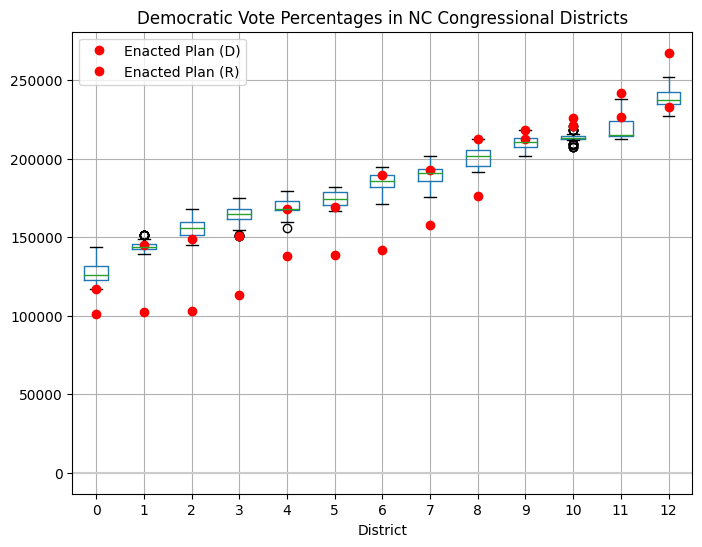

In [113]:

fig,	ax = plt.subplots(figsize=(8, 6))
ax.axhline(0.5, color="#cccccc")

data_d.boxplot(ax=ax, positions=range(len(data_d.columns)))
plt.plot(data_d.iloc[0], "ro", label="Enacted Plan (D)")

# plt.plot(data_r.iloc[0], "ro", label="Enacted Plan (R)")

plt.legend()

ax.set_title("Democratic Vote Percentages in NC Congressional Districts")
ax.set_xlabel("District")
# ax.set_ylim(0, 1)
# ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.show()